In [1]:
import os
import pickle
import timeit
from datetime import datetime
import numpy as np
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
nlct_dir_path = "/home/jturner/false_low_clouds_2023/Nighttime_Low_Cloud_Test/nlct_data/"

In [3]:
nlct_dates = sorted(os.listdir(nlct_dir_path))

#--- Removing any non-date directory items
#--- Currently only including 2023
nlct_dates = [x for x in nlct_dates if len(x) == 8 and x[:6] == '202309']

['20230901',
 '20230902',
 '20230903',
 '20230904',
 '20230905',
 '20230906',
 '20230907',
 '20230908',
 '20230909',
 '20230910',
 '20230911',
 '20230912',
 '20230913',
 '20230914',
 '20230915',
 '20230916',
 '20230917',
 '20230918',
 '20230919',
 '20230920',
 '20230921',
 '20230922',
 '20230923',
 '20230924',
 '20230925',
 '20230926',
 '20230927']

Creating the static feature function: 

In [4]:
def get_static_features(BTD_c, nlct_dir_path, nlct_date):
    #--- Initialize an array of 1's in the shape of the final image
    BTD_prod = [ [1]*len(BTD_c[0][0]) for i in range(len(BTD_c[0]))]

    #--- Starting the timer
    starttime = timeit.default_timer()

    #--- Include all times or just top of hour (TOH)
    all_files = sorted(os.listdir(nlct_dir_path+nlct_date+'/'))
    toh_files = [filename for filename in all_files if filename.endswith('00M')]

    for filename in toh_files:
            #print(filename)

            #--- Open the NLCT file
            file = open(nlct_dir_path+nlct_date+'/'+filename, 'rb')
            BTD = pickle.load(file)
            file.close()

            #--- Crop to the specified region
            BTD = BTD.where((BTD.lat>min_lat) & (BTD.lat<max_lat) & (BTD.lon>min_lon) & (BTD.lon<max_lon))
            BTD = BTD.dropna(dim="y", how="all")
            BTD = BTD.dropna(dim="x", how="all")

            #--- Set negative values to zero
            BTD = np.where(BTD < 0, 0, BTD)

            #--- V1: Multiply to only enhance static clouds
            #BTD_prod = BTD_prod*BTD

            #--- V1: Limit runaway large values to 3
            #BTD_prod = np.where(BTD_prod > 3, 3, BTD_prod)
            
            #--- Mitigating error where BTD is not loaded
            if np.shape(BTD) == (1,0,0):
                BTD = [ [0]*len(BTD_c[0][0]) for i in range(len(BTD_c[0]))]
            
            #--- V2: Sum to enhance static clouds
            BTD_prod = BTD_prod+BTD


    #print("Completed: ", timeit.default_timer() - starttime)

    return BTD_prod

Creating the static value function: 

In [5]:
def get_static_values(BTD_c, nlct_dir_path, nlct_date):
    
    BTD_prod = get_static_features(BTD_c, nlct_dir_path, nlct_date)
            
    nlct_date2 = str(int(nlct_date)+1)

    BTD_prod2 = get_static_features(BTD_c, nlct_dir_path, nlct_date2)
    
    BTD_tot = BTD_prod + BTD_prod2
    
    #--- V2: Limit to top 25%
    BTD_tot_lim = np.nan_to_num(BTD_tot, nan=0)
    BTD_tot_lim = BTD_tot_lim/np.max(BTD_tot_lim)
    limit = 0.75
    BTD_tot_lim = np.where(BTD_tot_lim < limit, 0, BTD_tot_lim)
    BTD_tot_lim = np.where(BTD_tot_lim > limit, 1, BTD_tot_lim)

    #--- Convert BTD prod (2d array) to value
    static_value = np.nansum(BTD_tot_lim)

    #--- Create date variable
    date = datetime.strptime(nlct_date, "%Y%m%d")
    
    return date, static_value

Create sample to use as framework for loop:

In [6]:
sample_date = '20220914'
sample_nlct_path = "/home/jturner/false_low_clouds_2023/Nighttime_Low_Cloud_Test/nlct_data/"+sample_date+"/"
sample_filename = 'goes_e_ntlc_'+sample_date[0:4]+'_'+sample_date[4:6]+'_'+sample_date[6:8]+'_00H_00M'

file = open(sample_nlct_path+sample_filename, 'rb')
BTD = pickle.load(file)
file.close()

#---Georges Bank
min_lon = -71.5
min_lat = 37
max_lon = -64
max_lat = 42.5

BTD_c = BTD.where((BTD.lat>min_lat) & (BTD.lat<max_lat) & (BTD.lon>min_lon) & (BTD.lon<max_lon))
BTD_c = BTD_c.dropna(dim="y", how="all")
BTD_c = BTD_c.dropna(dim="x", how="all")

Running the static value function for each date in NLCT directory: 

In [7]:
data = {'Date': [], 'StaticValue': []}
df = pd.DataFrame(data)

In [8]:
for nlct_date in tqdm(nlct_dates[:-1], desc="Processing", ncols=100):
    date, static_value = get_static_values(BTD_c, nlct_dir_path, nlct_date)
    #print(date, static_value)
    
    data_to_add = {
        'Date': date,
        'StaticValue': static_value
    }
    df = df.append(data_to_add, ignore_index=True)

Processing:   0%|                                                            | 0/26 [00:00<?, ?it/s]

Completed:  13.388722736388445


Processing:   4%|██                                                  | 1/26 [00:27<11:26, 27.46s/it]

Completed:  13.873017691075802
Completed:  7.732973139733076


Processing:   8%|████                                                | 2/26 [00:49<09:35, 24.00s/it]

Completed:  13.644932676106691
Completed:  9.207852154970169


Processing:  12%|██████                                              | 3/26 [01:19<10:18, 26.90s/it]

Completed:  20.94365868717432
Completed:  8.17849225178361


Processing:  15%|████████                                            | 4/26 [01:41<09:14, 25.20s/it]

Completed:  14.219766400754452
Completed:  7.806867208331823


Processing:  19%|██████████                                          | 5/26 [02:05<08:35, 24.53s/it]

Completed:  15.323133401572704
Completed:  7.832395203411579


Processing:  23%|████████████                                        | 6/26 [02:35<08:50, 26.52s/it]

Completed:  22.36332108452916
Completed:  8.452459830790758


Processing:  27%|██████████████                                      | 7/26 [02:58<08:00, 25.31s/it]

Completed:  14.172158375382423
Completed:  8.434715989977121


Processing:  31%|████████████████                                    | 8/26 [03:27<07:54, 26.34s/it]

Completed:  19.908794086426497
Completed:  8.410239730030298


Processing:  35%|██████████████████                                  | 9/26 [03:56<07:46, 27.46s/it]

Completed:  21.284782100468874
Completed:  8.101908899843693


Processing:  38%|███████████████████▌                               | 10/26 [04:19<06:54, 25.93s/it]

Completed:  14.231908664107323
Completed:  7.973140627145767


Processing:  42%|█████████████████████▌                             | 11/26 [04:48<06:43, 26.87s/it]

Completed:  20.83052981644869
Completed:  6.426063664257526


Processing:  46%|███████████████████████▌                           | 12/26 [05:16<06:20, 27.19s/it]

Completed:  21.292424127459526
Completed:  8.236181415617466


Processing:  50%|█████████████████████████▌                         | 13/26 [05:38<05:34, 25.74s/it]

Completed:  13.98211269453168
Completed:  8.008277848362923


Processing:  54%|███████████████████████████▍                       | 14/26 [06:01<04:57, 24.79s/it]

Completed:  14.394592005759478
Completed:  7.960326164960861


Processing:  58%|█████████████████████████████▍                     | 15/26 [06:31<04:50, 26.36s/it]

Completed:  21.85660395026207
Completed:  7.68819735199213


Processing:  62%|███████████████████████████████▍                   | 16/26 [06:52<04:08, 24.82s/it]

Completed:  13.344714254140854
Completed:  7.635762874037027


Processing:  65%|█████████████████████████████████▎                 | 17/26 [07:13<03:33, 23.73s/it]

Completed:  13.362051732838154
Completed:  8.015052624046803


Processing:  69%|███████████████████████████████████▎               | 18/26 [07:43<03:22, 25.37s/it]

Completed:  20.985168546438217
Completed:  8.097195621579885


Processing:  73%|█████████████████████████████████████▎             | 19/26 [08:04<02:49, 24.24s/it]

Completed:  13.320160016417503
Completed:  7.217432837933302


Processing:  77%|███████████████████████████████████████▏           | 20/26 [08:26<02:20, 23.39s/it]

Completed:  13.994636937975883
Completed:  8.266843818128109


Processing:  81%|█████████████████████████████████████████▏         | 21/26 [08:55<02:06, 25.35s/it]

Completed:  21.46140520647168
Completed:  8.089947450906038


Processing:  85%|███████████████████████████████████████████▏       | 22/26 [09:17<01:36, 24.18s/it]

Completed:  13.181666232645512
Completed:  8.213206321001053


Processing:  88%|█████████████████████████████████████████████      | 23/26 [09:45<01:16, 25.43s/it]

Completed:  19.921632017940283
Completed:  8.898070678114891


Processing:  92%|███████████████████████████████████████████████    | 24/26 [10:09<00:49, 24.86s/it]

Completed:  14.420508246868849
Completed:  8.597008913755417


Processing:  96%|█████████████████████████████████████████████████  | 25/26 [10:33<00:24, 24.77s/it]

Completed:  15.78104455024004
Completed:  7.939843125641346


Processing: 100%|███████████████████████████████████████████████████| 26/26 [10:55<00:00, 25.22s/it]

Completed:  13.767123959958553


In [9]:
df

,Date,StaticValue
0,2023-09-01,203.0
1,2023-09-02,730.0
2,2023-09-03,1078.0
3,2023-09-04,668.0
4,2023-09-05,340.0
5,2023-09-06,349.0
6,2023-09-07,874.0
7,2023-09-08,221.0
8,2023-09-09,181.0
9,2023-09-10,335.0


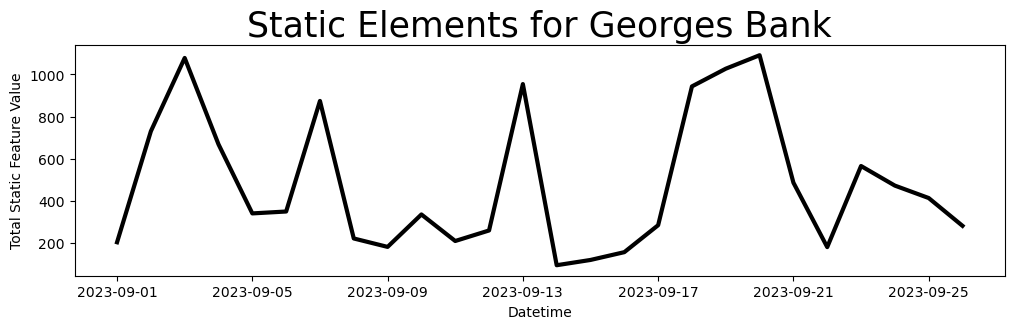

In [10]:
fig,ax=plt.subplots(1, figsize=(12,3))
ax.set_ylabel("Total Static Feature Value", fontsize=10)
ax.set_xlabel("Datetime", fontsize=10)
ax.set_title("Static Elements for Georges Bank", fontsize=25)

ax.plot(df.Date, df.StaticValue, c='black', linewidth=3)